In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

import matplotlib.pyplot as plt
import random

This notebook will use soccer data from Kaggle to test the U-net (Ronneberger, 2015) (if a CPU can manage this)

The model architecture is unfinished.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, true_image_paths, masked_image_paths, transform=None):
        self.true_image_paths = true_image_paths
        self.masked_image_paths = masked_image_paths
        self.transform = transform

    def __len__(self):
        return len(self.true_image_paths)

    def __getitem__(self, idx):
        true_img_path = self.true_image_paths[idx]
        masked_img_path = self.masked_image_paths[idx]
        
        true_image = Image.open(true_img_path).convert("RGB")
        masked_image = Image.open(masked_img_path).convert("RGB")
        
        if self.transform:
            true_image = self.transform(true_image)
            masked_image = self.transform(masked_image)
        
        return true_image, masked_image

class DataLoader:
    def __init__(self, base_folder, resize_to=(256, 256)):
        self.base_folder = base_folder
        self.resize_to = resize_to
        self.true_image_paths = []
        self.masked_image_paths = []

    def load_images(self):
        images_folder = os.path.join(self.base_folder, 'images')
        masks_folder = os.path.join(self.base_folder, 'masks')

        if not os.path.isdir(images_folder) or not os.path.isdir(masks_folder):
            raise FileNotFoundError("The specified image or mask folders do not exist.")
        
        image_files = os.listdir(images_folder)
        mask_files = os.listdir(masks_folder)

        # Ensure both directories have corresponding files
        for image_file in image_files:
            image_path = os.path.join(images_folder, image_file)
            mask_path = os.path.join(masks_folder, image_file)  # Assuming same filename

            if os.path.isfile(image_path) and os.path.isfile(mask_path):
                self.true_image_paths.append(image_path)
                self.masked_image_paths.append(mask_path)

    def get_data(self):
        transform = transforms.Compose([
            transforms.Resize(self.resize_to),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for pre-trained models
        ])

        dataset = ImageDataset(self.true_image_paths, self.masked_image_paths, transform=transform)
        data_loader = TorchDataLoader(dataset, batch_size=16, shuffle=True)
        
        return data_loader

    def display_images(self, num_images=5):
        """Display random true images above their corresponding masked images."""
        random_indices = random.sample(range(len(self.true_image_paths)), num_images)
        
        fig, axes = plt.subplots(2, num_images, figsize=(15, 7)) 
        
        for i, idx in enumerate(random_indices):
            true_image_path = self.true_image_paths[idx]
            masked_image_path = self.masked_image_paths[idx]
            
            true_image = Image.open(true_image_path).resize(self.resize_to)
            masked_image = Image.open(masked_image_path).resize(self.resize_to)
            
            axes[0, i].imshow(true_image)
            axes[0, i].set_title(f"True Image {i+1}")
            axes[0, i].axis('off')
            
            axes[1, i].imshow(masked_image)
            axes[1, i].set_title(f"Masked Image {i+1}")
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

    def return_data(self):
        """Export the true and masked images in PyTorch format."""
        transform = transforms.Compose([
            transforms.Resize(self.resize_to),
            transforms.ToTensor(),
        ])

        true_images = []
        masked_images = []

        for true_img_path, masked_img_path in zip(self.true_image_paths, self.masked_image_paths):
            true_image = Image.open(true_img_path).convert("RGB")
            masked_image = Image.open(masked_img_path).convert("RGB")

            true_image = transform(true_image)
            masked_image = transform(masked_image)

            true_images.append(true_image)
            masked_images.append(masked_image)

        real_images_tensor = torch.stack(true_images)
        masked_images_tensor = torch.stack(masked_images)

        return real_images_tensor, masked_images_tensor

Now the original images and the manually segmented images are plotted

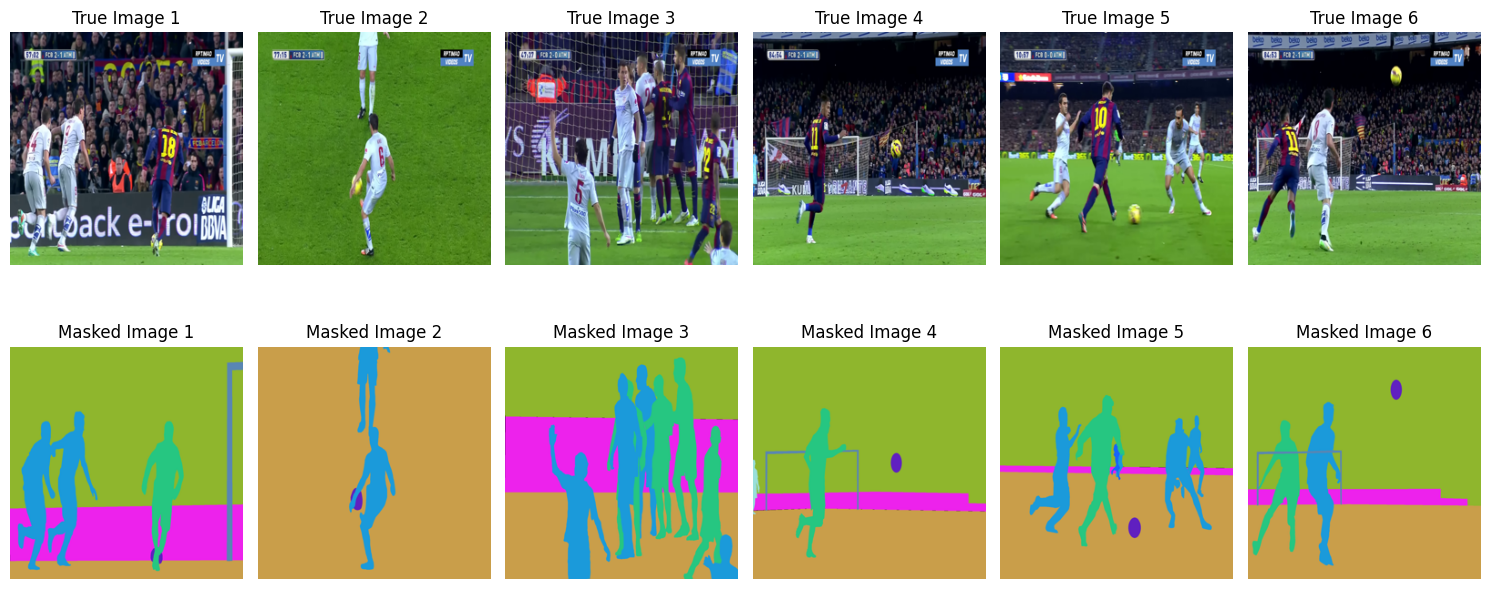

torch.Size([100, 3, 256, 256]) torch.Size([100, 3, 256, 256])


In [6]:
base_folder = '.\\data\\football-match-semantic-segmentation\\versions\\1'
data_loader = DataLoader(base_folder)
data_loader.load_images()
data_loader.display_images(num_images=6)
real_images, masked_images = data_loader.return_data()
print(real_images.shape, masked_images.shape)

The U-net architecture consists of a repeated pattern. For example the combination of Conv2d, Conv2d and Maxpool2d is used three times in a row. Therefore we make a separate class that performs this so that the coding of the final architecture is cleaner.

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=5, stride=5, padding=1):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,   out_channels=2*in_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*in_channels, out_channels=4*in_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.block(x)
    
class BottleNeckBlock(nn.Module):
    def __init__(self, in_channels):
        super(BottleNeckBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1), # Should double the pixels
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.block(x)

class UpConvBlock(nn.Module):
    def __init__(self, in_channels):
        super(UpConvBlock, self).__init__()

        concatenation_block = 1 # paste concatenation block here. Resize to the input of the first transposeconv2d

        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels,    out_channels=in_channels//2, kernel_size=5, stride=5, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.block(x)

class Unet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Unet, self).__init__()
        
        # Contracting network
        self.convblock1 = ConvBlock(3, 8)
        self.convblock2 = ConvBlock(self.convblock2, 8, 16)
        self.convblock3 = ConvBlock(self.convblock3, 16, 32)
        self.convblock4 = ConvBlock(self.convblock4, 64)

        # Bottleneck part of th enetwork
        self.bottleneck = BottleNeckBlock(self.convblock4, 64)

        # Expanding network
        self.expandingblock1 = UpConvBlock(self.bottleneck, 64)
        self.expandingblock2 = UpConvBlock(self.expandingblock1, 64)
        self.expandingblock3 = UpConvBlock(self.expandingblock2, 64)
        self.expandingblock4 = UpConvBlock(self.expandingblock3, 64)

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        return x


In [ ]:
input_size = 1920*1080*3 # 1920x1080 RBG images
hidden_size = 128        # Convolution compression
output_size = 10         # Maxpool compression

model = FeedForwardNN(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(model, criterion, optimizer, train_loader, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Example testing function
# def test(model, test_loader):
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     accuracy = 100 * correct / total
#     print(f"Accuracy: {accuracy:.2f}%")